# Import Libraries and Constant

In [1]:
import os, time
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError, ImageFile
import psutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [4]:
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
IMAGE_SIZE = 128
LATENT_DIM = 256
L2_REG = 1e-5
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-4
TRAIN_SIZE = 25600
VAL_SIZE = 3200
TEST_SIZE = 3200
DATA_PATHS = {
    "train": r"train_data.npy",
    "val": r"val_data.npy",
    "test": r"test_data.npy"
}
DATA_DIR = "Plots"
MODEL_PATH = "saved_model_auto_encoder.keras"
DECODER_PATH = "saved_model_decoder.keras"
LOG_DIR = "./logs"

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(filepath=MODEL_PATH, save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir=LOG_DIR)
]

# All The Functions

In [8]:
def load_data(data_dir):
    # drive.mount('/content/drive')

    all_imgs = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x))))
    )

    train_files, test_files = train_test_split(all_imgs, test_size=0.3, random_state=42)
    val_files, test_files   = train_test_split(test_files, test_size=107, random_state=42)

    # train_files = all_imgs[:500]
    # val_files   = all_imgs[500:608]
    # test_files  = all_imgs[608:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    return train_files, val_files, test_files

In [9]:
def load_images(file_list):
    data = []
    for f in file_list:
        try:
            img = load_img(f, target_size=(128, 128), color_mode="rgb")
            arr = img_to_array(img) / 255.0
            data.append(arr)
        except (OSError, UnidentifiedImageError) as e:
            print(f"⚠️ Skipping corrupted image: {f} ({e})")
    return np.array(data)

In [10]:
def build_encoder(img_size, latent_dim):
  inputs = layers.Input(shape=(img_size, img_size, 3))

  # x = layers.Conv2D(8, (3,3), activation="relu", 
  #                   padding="same")(inputs)
  # x = layers.MaxPooling2D((2,2), padding="same")(x)

  x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
  x = layers.MaxPooling2D((2,2), padding="same")(x)

  x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
  x = layers.MaxPooling2D((2,2), padding="same")(x)

  x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
  # x = layers.MaxPooling2D((2,2), padding="same")(x)

  x = layers.Flatten()(x)
  outputs = layers.Dense(latent_dim, activation="relu")(x)

  return models.Model(inputs, outputs, name="Encoder")

In [11]:
def build_decoder(img_size, latent_dim):
  inputs = layers.Input(shape=(latent_dim,))

  x = layers.Dense((img_size//8) * (img_size//8) * 64, activation="relu")(inputs)
  x = layers.Reshape((img_size//8, img_size//8, 64))(x)

  x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)

  outputs = layers.Conv2DTranspose(3, (3,3), activation="sigmoid", padding="same")(x)

  return models.Model(inputs, outputs, name="Decoder")

In [12]:
def plot_metrics(history):
    plt.figure(figsize=(15,10))

    # Loss convergence
    plt.subplot(2,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training time per epoch
    plt.subplot(2,2,2)
    plt.plot(history["epoch_time"], marker="o")
    plt.title("Training Time per Epoch (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")

    # Gradient norm stability
    plt.subplot(2,2,3)
    plt.plot(history["grad_norm"], marker="x")
    plt.title("Gradient Norm per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("L2 Norm")

    # Memory footprint
    plt.subplot(2,2,4)
    plt.plot(history["memory_usage"], marker="s")
    plt.title("Memory Usage")
    plt.xlabel("Epoch")
    plt.ylabel("% Used (CPU) / MB (GPU)")

    plt.tight_layout()
    plt.show()

In [13]:
class MetricTracker(tf.keras.callbacks.Callback):
    def __init__(self, sample_data=None):
        super().__init__()
        self.sample_data = sample_data  # one batch of data (x, y)
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "epoch_time": [],
            "grad_norm": [],
            "memory_usage": []
        }

        # Detect GPU availability once at initialization
        gpus = tf.config.list_physical_devices('GPU')
        self.use_gpu = len(gpus) > 0
        if self.use_gpu:
            print(f"✅ GPU detected: {gpus[0].name}")
        else:
            print("⚠️ No GPU detected — tracking CPU memory instead.")

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        self.history["epoch_time"].append(end_time - self.start_time)
        self.history["train_loss"].append(logs.get("loss"))
        self.history["val_loss"].append(logs.get("val_loss"))

        # Gradient norm
        if self.sample_data is not None:
            x_sample, y_sample = self.sample_data
            with tf.GradientTape() as tape:
                y_pred = self.model(x_sample, training=True)

                # ▶ FIX: hitung loss manual, aman untuk semua versi TF
                loss_fn = self.model.loss
                reg_loss = tf.add_n(self.model.losses) if self.model.losses else 0.0
                loss_value = loss_fn(y_sample, y_pred) + reg_loss

            grads = tape.gradient(loss_value, self.model.trainable_weights)
            grad_norm = np.sqrt(sum([
                tf.reduce_sum(tf.square(g)).numpy()
                for g in grads if g is not None
            ]))
        else:
            grad_norm = np.nan

        self.history["grad_norm"].append(grad_norm)

        # Memory tracking
        if self.use_gpu:
            try:
                mem_info = tf.config.experimental.get_memory_info('GPU:0')
                current_mem_mb = mem_info['current'] / (1024 ** 2)
                self.history["memory_usage"].append(current_mem_mb)
            except:
                self.history["memory_usage"].append(np.nan)
        else:
            self.history["memory_usage"].append(psutil.cpu_percent())


In [14]:
def build_train_autoencoder(img_size=128, latent_dim=64):
  encoder = build_encoder(img_size, latent_dim)
  decoder = build_decoder(img_size, latent_dim)
  inputs = layers.Input(shape=(img_size, img_size, 3))
  latent = encoder(inputs)
  outputs = decoder(latent)
  autoencoder = models.Model(inputs, outputs, name="Autoencoder")
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=MeanSquaredError())
  return autoencoder, encoder, decoder

In [15]:
def plot_loss(history):
    """Plots the training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
def visualize_result(autoencoder, test_data, noisy_data=None, num_images=5):
  if noisy_data is None:
    noisy_data = test_data

  reconstructed = autoencoder.predict(noisy_data)

  plt.figure(figsize=(10,9))
  for i in range(num_images):
    plt.subplot(3, num_images, i+1)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed", fontsize=14)
    plt.axis('off')

    plt.subplot(3, num_images, i+1+num_images)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title("Data Test", fontsize=14)
    plt.axis('off')

    plt.subplot(3, num_images, i+1+2*num_images)
    diff = np.abs(test_data[i] - reconstructed[i])
    plt.imshow(diff.squeeze(), cmap='hot')
    plt.title("Difference", fontsize=14)
    plt.axis('off')

  plt.suptitle('Predictions and Ground Truth with Dual Stage NN', fontsize=20)
  plt.tight_layout()
  plt.show()

In [17]:
#Magnitude
def add_magnitude_noise(images, noise_factor=0.1, mode="gaussian"):
  if mode == "gaussian":
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
  elif mode == "s&p":
    noisy = images.copy()
    prob = noise_factor
    rnd = np.random.rand(*images.shape)
    noisy[rnd < (prob/2)] = 0.0
    noisy[rnd > 1 - (prob/2)] = 1.0
  else:
    raise ValueError("Unsupported noise mode")
  return np.clip(noisy, 0., 1.)

In [18]:
def add_phase_noise(phase, noise_factor=0.02):
    # Tambahkan gaussian noise
    noisy = phase + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=phase.shape)

    # Wrap kembali ke range [-π, π]
    noisy = (noisy + np.pi) % (2 * np.pi) - np.pi

    return noisy

In [19]:
def pipeline():
    train_files, val_files, test_files = load_data(DATA_DIR)
    train_data = load_images(train_files)
    val_data   = load_images(val_files)
    test_data  = load_images(test_files)

    autoencoder, encoder, decoder = build_train_autoencoder(img_size=128, latent_dim=256)

    print("\n=== AUTOENCODER SUMMARY ===")
    autoencoder.summary()

    print("\n=== ENCODER SUMMARY ===")
    encoder.summary()

    print("\n=== DECODER SUMMARY ===")
    decoder.summary()

    metric_tracker = MetricTracker(sample_data=(train_data[:100], train_data[:100]))

    with tf.device('/GPU:0'):
      tf.debugging.set_log_device_placement(True)
      history = autoencoder.fit(
          train_data, train_data,
          validation_data=(val_data, val_data),
          epochs=30,
          batch_size=2,
          callbacks=[metric_tracker],
          verbose=1
      )

    autoencoder.save("model/autoencoder.keras")
    encoder.save("model/encoder.keras")
    decoder.save("model/decoder.keras")

    latent_train = encoder.predict(train_data)
    latent_val   = encoder.predict(val_data)
    latent_test  = encoder.predict(test_data)

    latent_all = np.concatenate([latent_train, latent_val, latent_test], axis=0)

    np.save("latent_rep/latent_all.npy", latent_all)
    np.save("latent_rep/latent_train.npy", latent_train)
    np.save("latent_rep/latent_val.npy", latent_val)
    np.save("latent_rep/latent_test.npy", latent_test)

    # noisy_test_data = add_noise(test_data, noise_factor=0.15, mode="gaussian")

    visualize_result(autoencoder, test_data)
    plot_loss(history)

    # Plot metrics collected from the custom callback
    plot_metrics(metric_tracker.history)

# Implementation

Train: 500, Val: 108, Test: 107

=== AUTOENCODER SUMMARY ===
Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 Encoder (Functional)        (None, 256)               16801056  
                                                                 
 Decoder (Functional)        (None, 128, 128, 3)       4271139   
                                                                 
Total params: 21,072,195
Trainable params: 21,072,195
Non-trainable params: 0
_________________________________________________________________

=== ENCODER SUMMARY ===
Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
      

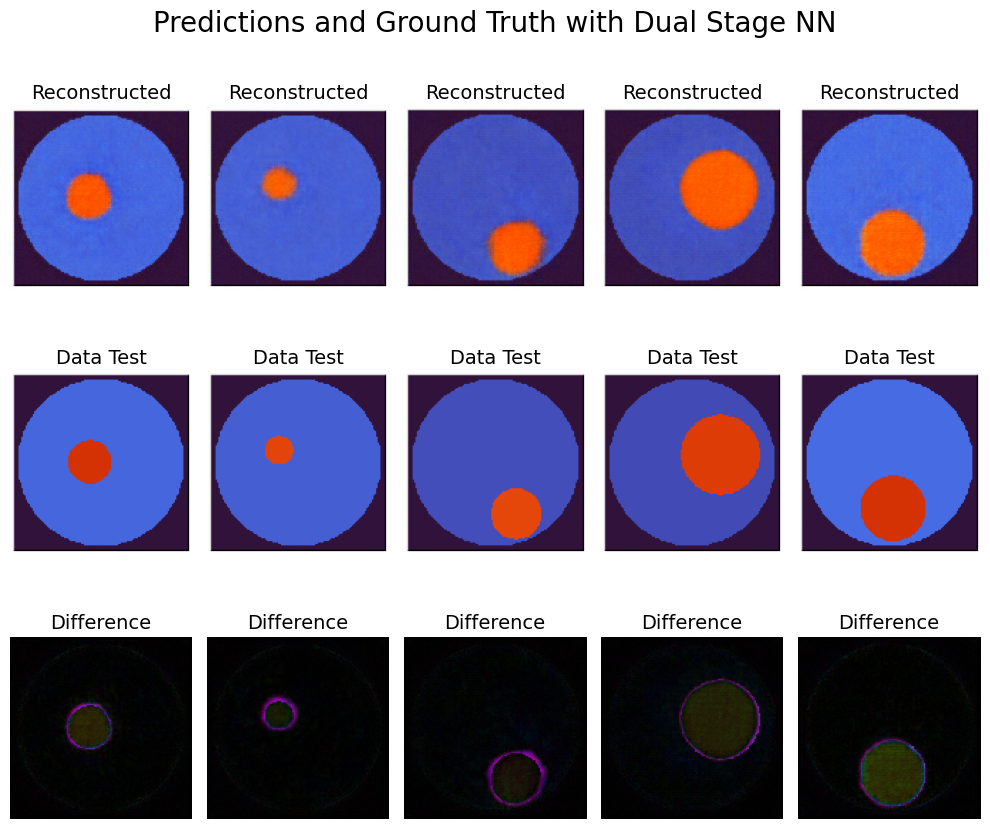

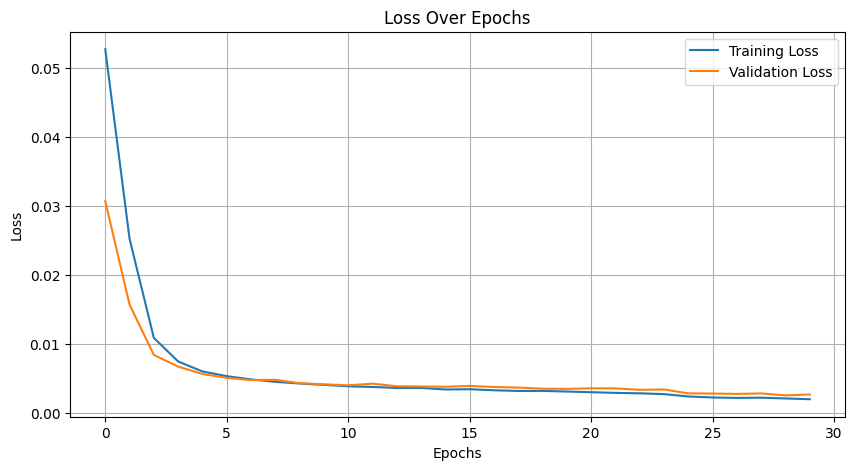

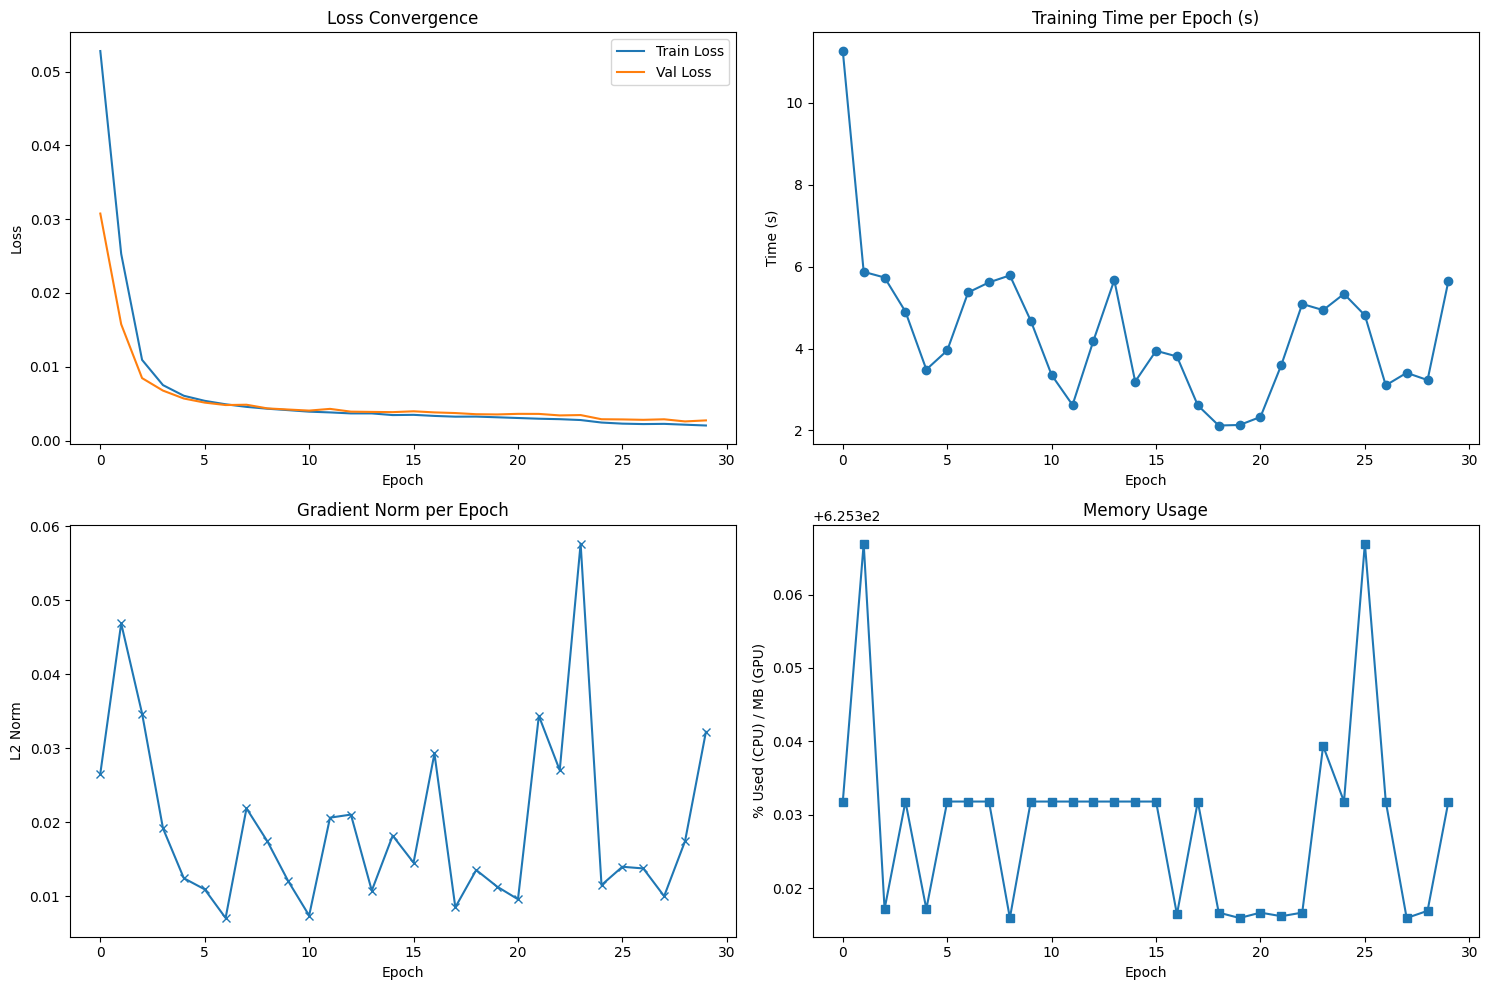

In [20]:
pipeline()

In [ ]:
train_files, val_files, test_files = load_data(DATA_DIR)
train_data = load_images(train_files)
val_data   = load_images(val_files)
test_data  = load_images(test_files)

print("Train data:", len(train_data))
print("Val data:", len(val_data))
print("Test data:", len(test_data))

In [ ]:
latent_rep_train = np.load("latent_rep/latent_train.npy")
latent_rep_val = np.load("latent_rep/latent_val.npy")
latent_rep_test = np.load("latent_rep/latent_test.npy")

In [ ]:
print("Latent Train:", latent_rep_train.shape)
print("Latent Val:", latent_rep_val.shape)
print("Latent Test:", latent_rep_test.shape)